In [1]:
# Import required libraries and dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


# Path to the data
file_path = Path("Resources/Cars.xlsx")

# Read in CSV file
table_df = pd.read_excel(file_path)

# Fix the year
table_df['Year'] = table_df['Year'].fillna(0).astype(int)
table_df.tail(5)

,Month,Year,Not seasonally adjusted (Thousands),"Combined seasonal, trading-day factor",Seasonally adjusted (Thousands),Seasonally adjusted at annual rates (Millions)
676,May,2023,205.765,105.85,194.393009,2.332716
677,June,2023,206.552,106.45,194.036637,2.328440
678,July,2023,191.771,97.20,197.295267,2.367543
679,August,2023,190.848,100.05,190.752624,2.289031
680,September,2023,196.482,101.45,193.673731,2.324085


In [3]:
# Extract the target variable
data = table_df['Seasonally adjusted  (Thousands)'].values

# Normalize the data 
scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape(-1, 1))

# Define a function to prepare the data
def prepare_sequence_data(data, time_steps):
    X, y, months, years = [], [], [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)].flatten())  # Flatten the sequence
        y.append(data[(i + 1):(i + time_steps + 1)].flatten())  # Flatten and Predict the next sequence
        months.append(table_df['Month'].iloc[i + time_steps])
        years.append(table_df['Year'].iloc[i + time_steps])
    return np.array(X), np.array(y), months, years

# Set the number of time steps and split the data
time_steps = 10  
X, y, months, years = prepare_sequence_data(data, time_steps)
X_train, X_test, y_train, y_test, months_train, months_test, years_train, years_test = train_test_split(X, y, months, years, test_size=0.2, shuffle=False)

# Build the LSTM model for forecasting
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled data to the original scale
y_test_original_scale = scaler.inverse_transform(y_test[:, -1].reshape(-1, 1))  
y_pred_original_scale = scaler.inverse_transform(y_pred[:, -1].reshape(-1, 1))

# Create a DataFrame with the original-scale data, months, and years
df = pd.DataFrame({'Month': months_test, 'Year': years_test, 'Actual': y_test_original_scale.flatten(), 'Predicted': y_pred_original_scale.flatten()})

Epoch 1/100
16/16 [==============================] - 2s 27ms/step - loss: 0.3324 - val_loss: 0.0457
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2008 - val_loss: 0.0171
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0956 - val_loss: 0.0280
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0697 - val_loss: 0.0164
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0569 - val_loss: 0.0173
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0462 - val_loss: 0.0154
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0365 - val_loss: 0.0176
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0310 - val_loss: 0.0200
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0275 - val_loss: 0.0171
Epoch 10/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0246 - val_loss: 0.0173
Epoch 11

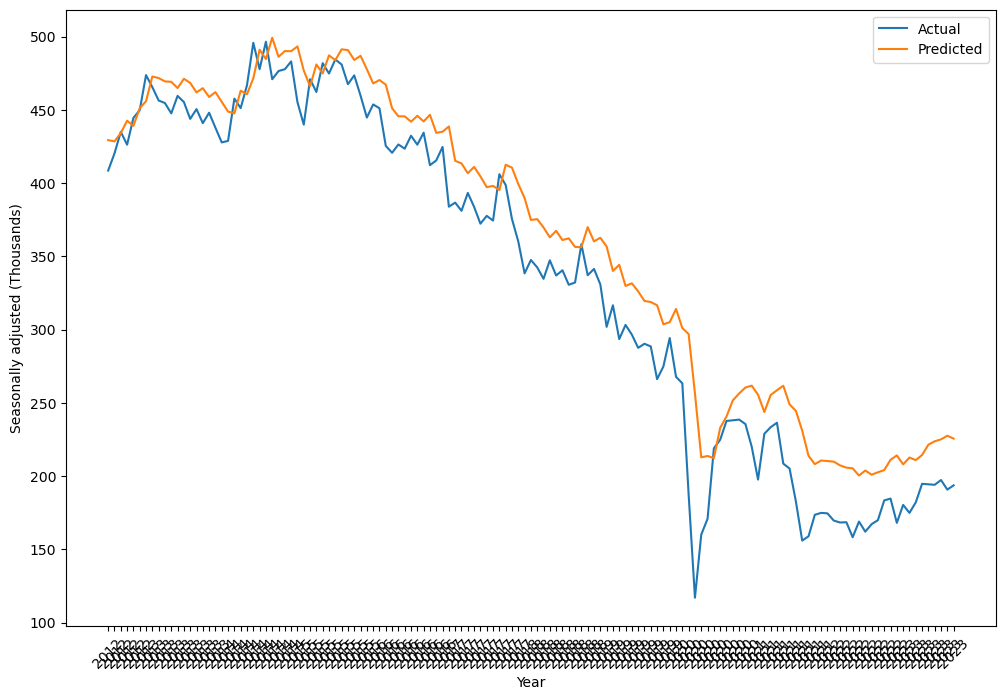

In [10]:
# Define years_test by extracting the corresponding years for the test data
years_test = table_df['Year'].values[-len(y_test):]

# Plot actual vs. predicted values with years on the x-axis (January of every 5 years)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(years_test)), y_test_original_scale, label='Actual')
plt.plot(np.arange(len(years_test)), y_pred_original_scale, label='Predicted')

# Set the x-axis ticks and labels as the year and rotate them for readability (didn't really work)
plt.xticks(np.arange(len(years_test)), years_test, rotation=45)
plt.xlabel('Year')
plt.ylabel('Seasonally adjusted (Thousands)')
plt.legend()
plt.show()

In [4]:
# Preview the dataframe
print(df)

         Month  Year      Actual   Predicted
0         July  2012  408.499434  429.283142
1       August  2012  420.224661  428.429413
2    September  2012  434.924796  434.087372
3      October  2012  426.173548  442.532593
4     November  2012  444.474188  439.018555
..         ...   ...         ...         ...
130        May  2023  194.393009  221.406097
131       June  2023  194.036637  223.739868
132       July  2023  197.295267  225.038147
133     August  2023  190.752624  227.552322
134  September  2023  193.673731  225.550949

[135 rows x 4 columns]


In [7]:
# Create an additional column that combines month and year
df['Date'] = pd.to_datetime(df['Year'].astype(str) + df['Month'], format='%Y%B')
df['Date'] = df['Date'].dt.to_period('M')

print(df)

         Month  Year      Actual   Predicted     Date
0         July  2012  408.499434  429.283142  2012-07
1       August  2012  420.224661  428.429413  2012-08
2    September  2012  434.924796  434.087372  2012-09
3      October  2012  426.173548  442.532593  2012-10
4     November  2012  444.474188  439.018555  2012-11
..         ...   ...         ...         ...      ...
130        May  2023  194.393009  221.406097  2023-05
131       June  2023  194.036637  223.739868  2023-06
132       July  2023  197.295267  225.038147  2023-07
133     August  2023  190.752624  227.552322  2023-08
134  September  2023  193.673731  225.550949  2023-09

[135 rows x 5 columns]


In [9]:
# Save the DataFrame to a CSV file
df.to_csv('lstm_predictions.csv', index=False)